In [32]:
import librosa
import numpy as np
import os
import math
from sklearn.cluster import KMeans
import hmmlearn.hmm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pickle

## Get MFCC function

In [2]:
# read file
def get_mfcc(file_path):
    y, sr = librosa.load(file_path) # read .wav file
    hop_length = math.floor(sr*0.010) # 10ms hop
    win_length = math.floor(sr*0.025) # 25ms frame
    # mfcc is 12 x T matrix
    mfcc = librosa.feature.mfcc(
        y, sr, n_mfcc=12, n_fft=1024,
        hop_length=hop_length, win_length=win_length)
    # substract mean from mfcc --> normalize mfcc
    mfcc = mfcc - np.mean(mfcc, axis=1).reshape((-1,1)) 
    # delta feature 1st order and 2nd order
    delta1 = librosa.feature.delta(mfcc, order=1)
    delta2 = librosa.feature.delta(mfcc, order=2)
    # X is 36 x T
    X = np.concatenate([mfcc, delta1, delta2], axis=0) # O^r
    # return T x 36 (transpose of X)
    return X.T # hmmlearn use T x N matrix

## lấy mfcc của tất cả các file trong dir

In [3]:
# lấy mfcc của tất cả các file wav trong wav
def get_class_data(data_dir):
    files = os.listdir(data_dir)
    mfcc = [get_mfcc(os.path.join(data_dir,f)) for f in files if f.endswith(".wav")]
    return mfcc

## Hàm Clustering

In [4]:
def clustering(X, n_clusters=14):
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0, verbose=0)
    kmeans.fit(X)
    print("centers", kmeans.cluster_centers_.shape)
    return kmeans

## plot biểu đồ predict/true

In [5]:
def plotCM(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('test')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('predicted')
    plt.ylabel('true')
    plt.show()

## Data

In [6]:
class_names = ['cothe', 'chungta', 'duoc', 'nguoi','trong']
dataset = {}
for cname in class_names:
    print(f"Load {cname} dataset")
    dataset[cname] = get_class_data(os.path.join('data',cname))

Load cothe dataset
Load chungta dataset
Load duoc dataset
Load nguoi dataset
Load trong dataset


In [7]:
print(len(dataset['cothe']))
print(len(dataset['chungta']))
print(len(dataset['duoc']))
print(len(dataset['nguoi']))
print(len(dataset['trong']))

124
100
105
100
150


In [8]:
testClass_names = ['chungta', 'duoc', 'trong', 'nguoi', 'cothe']
n_testDataSet = {'cothe': 0, 'chungta': 0, 'duoc': 0, 'nguoi': 0,'trong': 0}
testDataSet = {}
for cname in testClass_names:
    print(f"Load {cname} testDataSet")
    testDataSet[cname] = get_class_data(os.path.join('test', cname))
    n_testDataSet[cname] = len(testDataSet[cname])
print(len(testDataSet['chungta']))
print(len(testDataSet['duoc']))
print(len(testDataSet['trong']))
print(len(testDataSet['nguoi']))
print(len(testDataSet['cothe']))
print(n_testDataSet)

Load chungta testDataSet
Load duoc testDataSet
Load trong testDataSet
Load nguoi testDataSet
Load cothe testDataSet
5
5
5
5
5
{'cothe': 5, 'chungta': 5, 'duoc': 5, 'nguoi': 5, 'trong': 5}


## split train test

In [9]:
trainset = {}
testset = {}
n_test = {'cothe': 0, 'chungta': 0, 'duoc': 0, 'nguoi': 0,'trong': 0}
for cname in class_names:
    n = len(dataset[cname])
    n_train = math.floor(n*0.8)
    trainset[cname] = dataset[cname][:n_train]
    testset[cname] = dataset[cname][n_train:]
    n_test[cname] += len(testset[cname])
    
print(len(trainset['cothe']))
print(len(trainset['chungta']))
print(len(trainset['duoc']))
print(len(trainset['nguoi']))
print(len(trainset['trong']))

99
80
84
80
120


## Fit kmeans trên tập train

In [35]:
# Get all vectors in the datasets
all_vectors = np.concatenate([np.concatenate(v, axis=0) for k, v in trainset.items()], axis=0)
print("vectors", all_vectors.shape)
# Run K-Means algorithm to get clusters
kmeans = clustering(all_vectors)
print("centers", kmeans.cluster_centers_.shape)
print(kmeans)
fileNameKmeans = 'kmeans.sav'
pickle.dump(kmeans, open(fileNameKmeans, 'wb'))

vectors (14257, 1)
centers (14, 1)
centers (14, 1)
KMeans(n_clusters=14, n_init=50, random_state=0)


In [11]:
for cname in class_names:
    trainset[cname] = list([kmeans.predict(v).reshape(-1, 1) for v in trainset[cname]])
    testset[cname] = list([kmeans.predict(v).reshape(-1, 1) for v in testset[cname]])
for cname in testClass_names:
    testDataSet[cname] = list([kmeans.predict(v).reshape(-1, 1) for v in testDataSet[cname]])
    
    

# Train

In [12]:
models = {}

## Models cho 'có thể' 4x3

In [13]:
hmm = hmmlearn.hmm.MultinomialHMM(n_components=4*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ],])


Xbn = np.concatenate(trainset['cothe'])
lengths = list([len(x) for x in trainset['cothe']])
print("training class", 'cothe')
print(Xbn.shape, lengths, len(lengths))
hmm.fit(Xbn, lengths=lengths)
models['cothe'] = hmm
print("Training done")

training class cothe
(4501, 1) [34, 31, 56, 39, 44, 40, 46, 35, 45, 47, 37, 56, 36, 31, 39, 35, 42, 30, 30, 37, 36, 39, 26, 34, 47, 36, 41, 34, 26, 30, 25, 27, 16, 39, 27, 52, 25, 27, 20, 22, 36, 53, 44, 44, 28, 57, 53, 36, 37, 30, 34, 38, 51, 43, 40, 47, 38, 44, 102, 44, 52, 56, 35, 37, 39, 25, 41, 52, 43, 33, 49, 59, 35, 42, 40, 37, 40, 35, 36, 28, 45, 44, 23, 30, 48, 35, 32, 35, 35, 26, 36, 43, 45, 62, 165, 163, 179, 165, 158] 99


         1      -11236.2083             +nan
         2       -8061.2830       +3174.9253
         3       -7035.6852       +1025.5978
         4       -6801.1138        +234.5715
         5       -6705.6262         +95.4876
         6       -6659.4709         +46.1553
         7       -6599.8659         +59.6050
         8       -6468.8281        +131.0378
         9       -6401.4080         +67.4201
        10       -6249.9008        +151.5072
        11       -6183.5637         +66.3371
        12       -6178.4992          +5.0645
        13       -6175.1820          +3.3172
        14       -6172.6610          +2.5210
        15       -6169.7157          +2.9453
        16       -6164.2804          +5.4353
        17       -6155.4603          +8.8201
        18       -6146.2674          +9.1928
        19       -6141.7276          +4.5398
        20       -6138.1080          +3.6196
        21       -6134.8941          +3.2139
        22       -6133.9149          +0.9792
        23

Training done


        36       -6127.3915          +0.0072


#Models cho 'đã' 2x3

In [14]:
"""
hmm = hmmlearn.hmm.MultinomialHMM(n_components=2*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0 ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.3],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],])

Xct = np.concatenate(trainset['da'])
lengths = list([len(x) for x in trainset['da']])
print("training class", 'da')
print(Xct.shape, lengths, len(lengths))
hmm.fit(Xct, lengths=lengths)
models['da'] = hmm
print("Training done")"""

'\nhmm = hmmlearn.hmm.MultinomialHMM(n_components=2*3, random_state=0, n_iter=1000, verbose=True, init_params=\'e\', params=\'ste\')\nhmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0 ])\nhmm.transmat_ =np.array([\n    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0],\n    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0],\n    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0],\n    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1],\n    [0.0, 0.0, 0.0, 0.0, 0.7, 0.3],\n    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],])\n\nXct = np.concatenate(trainset[\'da\'])\nlengths = list([len(x) for x in trainset[\'da\']])\nprint("training class", \'da\')\nprint(Xct.shape, lengths, len(lengths))\nhmm.fit(Xct, lengths=lengths)\nmodels[\'da\'] = hmm\nprint("Training done")'

## Models cho 'chúng ta'

In [15]:
hmm = hmmlearn.hmm.MultinomialHMM(n_components=5*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ],])

Xct = np.concatenate(trainset['chungta'])
lengths = list([len(x) for x in trainset['chungta']])
print("training class", 'chungta')
print(Xct.shape, lengths, len(lengths))
hmm.fit(Xct, lengths=lengths)
models['chungta'] = hmm
print("Training done")

         1       -8271.5705             +nan


training class chungta
(3266, 1) [41, 46, 47, 36, 43, 34, 36, 42, 36, 40, 37, 36, 30, 40, 36, 41, 36, 37, 36, 42, 40, 39, 35, 38, 38, 41, 36, 44, 38, 59, 49, 37, 43, 35, 52, 42, 50, 48, 46, 54, 55, 47, 45, 38, 39, 38, 42, 38, 43, 33, 35, 32, 42, 32, 41, 34, 40, 37, 35, 37, 47, 31, 34, 36, 34, 31, 43, 30, 37, 54, 42, 40, 75, 45, 51, 57, 43, 41, 39, 37] 80


         2       -5558.3168       +2713.2537
         3       -4612.2937        +946.0231
         4       -4303.7596        +308.5341
         5       -4191.5242        +112.2354
         6       -4134.2702         +57.2540
         7       -4091.8013         +42.4689
         8       -4060.4839         +31.3174
         9       -4039.7614         +20.7224
        10       -4026.4939         +13.2676
        11       -4018.5230          +7.9709
        12       -4013.8090          +4.7140
        13       -4010.8374          +2.9716
        14       -4008.7758          +2.0616
        15       -4007.1677          +1.6081
        16       -4005.7134          +1.4542
        17       -4004.1600          +1.5535
        18       -4002.3590          +1.8010
        19       -4000.3585          +2.0006
        20       -3998.0150          +2.3434
        21       -3994.9080          +3.1071
        22       -3990.4830          +4.4250
        23       -3984.4733          +6.0097
        24

Training done


        78       -3910.3034          +0.0101
        79       -3910.2939          +0.0095


## Models cho 'được' 4x3

In [16]:
hmm = hmmlearn.hmm.MultinomialHMM(n_components=4*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ],])

Xcth = np.concatenate(trainset['duoc'])
lengths = list([len(x) for x in trainset['duoc']])
print("training class", 'duoc')
print(Xcth.shape, lengths, len(lengths))
hmm.fit(Xcth, lengths=lengths)
models['duoc'] = hmm
print("Training done")

         1       -4689.2294             +nan
         2       -3287.9123       +1401.3170


training class duoc
(1856, 1) [25, 20, 19, 17, 14, 22, 21, 23, 23, 30, 15, 18, 21, 30, 19, 20, 21, 30, 22, 14, 17, 23, 23, 19, 21, 18, 18, 20, 38, 21, 22, 35, 29, 18, 19, 22, 42, 22, 20, 24, 22, 21, 22, 22, 44, 29, 18, 14, 20, 24, 22, 19, 41, 24, 20, 18, 16, 20, 18, 21, 22, 30, 17, 21, 19, 16, 19, 18, 19, 16, 20, 14, 17, 16, 32, 26, 28, 24, 25, 25, 29, 21, 15, 17] 84


         3       -2854.7074        +433.2049
         4       -2685.9563        +168.7510
         5       -2616.0288         +69.9275
         6       -2568.3180         +47.7108
         7       -2522.8631         +45.4549
         8       -2482.7672         +40.0959
         9       -2447.7714         +34.9958
        10       -2420.2186         +27.5528
        11       -2404.1584         +16.0602
        12       -2395.2353          +8.9231
        13       -2389.4213          +5.8140
        14       -2385.7873          +3.6340
        15       -2383.8428          +1.9445
        16       -2382.7132          +1.1296
        17       -2381.9218          +0.7914
        18       -2381.2922          +0.6296
        19       -2380.7532          +0.5389
        20       -2380.2961          +0.4571
        21       -2379.9350          +0.3611
        22       -2379.6690          +0.2660
        23       -2379.4766          +0.1924
        24       -2379.3326          +0.1440
        25

Training done



        73       -2370.1997          +0.0099


## Models cho 'người' 4x3

In [17]:
hmm = hmmlearn.hmm.MultinomialHMM(n_components=4*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ], ])

Xcth = np.concatenate(trainset['nguoi'])
lengths = list([len(x) for x in trainset['nguoi']])
print("training class", 'nguoi')
print(Xcth.shape, lengths, len(lengths))
hmm.fit(Xcth, lengths=lengths)
models['nguoi'] = hmm
print("Training done")

         1       -4899.2129             +nan


training class nguoi
(1892, 1) [20, 18, 23, 25, 25, 38, 20, 25, 27, 22, 23, 23, 20, 26, 23, 19, 28, 24, 25, 19, 22, 28, 19, 24, 28, 20, 20, 32, 20, 18, 20, 31, 22, 19, 24, 14, 22, 15, 13, 22, 19, 25, 18, 27, 20, 20, 24, 17, 22, 19, 22, 26, 20, 23, 35, 28, 22, 30, 25, 27, 26, 23, 31, 30, 21, 19, 18, 20, 22, 15, 26, 19, 22, 51, 37, 42, 29, 29, 19, 18] 80


         2       -3286.9278       +1612.2851
         3       -2905.6138        +381.3141
         4       -2683.3534        +222.2603
         5       -2552.1228        +131.2306
         6       -2498.4975         +53.6253
         7       -2480.1086         +18.3889
         8       -2471.5025          +8.6061
         9       -2469.0258          +2.4767
        10       -2467.4589          +1.5669
        11       -2466.2027          +1.2562
        12       -2465.0254          +1.1773
        13       -2463.8099          +1.2155
        14       -2462.4436          +1.3664
        15       -2460.8176          +1.6260
        16       -2458.8748          +1.9428
        17       -2456.7023          +2.1724
        18       -2454.5948          +2.1075
        19       -2452.8868          +1.7080
        20       -2451.6773          +1.2096
        21       -2450.8438          +0.8334
        22       -2450.2281          +0.6158
        23       -2449.7209          +0.5072
        24

Training done


        35       -2447.6836          +0.0139
        36       -2447.6740          +0.0096


## Models cho 'trong' 3x3

In [18]:
hmm = hmmlearn.hmm.MultinomialHMM(n_components=3*3, random_state=0, n_iter=1000, verbose=True, init_params='e', params='ste')
hmm.startprob_ = np.array([0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ])
hmm.transmat_ =np.array([
    [0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, 0.0, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.2, 0.1, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.3, ],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ],])

Xvn = np.concatenate(trainset['trong'])
lengths = list([len(x) for x in trainset['trong']])
print("training class", 'trong')
print(Xvn.shape, lengths, len(lengths))
hmm.fit(Xvn, lengths=lengths)
models['trong'] = hmm
print("Training done")

         1       -6979.2600             +nan
         2       -4976.1457       +2003.1143


training class trong
(2742, 1) [19, 23, 17, 30, 26, 38, 23, 21, 22, 24, 32, 32, 22, 29, 22, 18, 25, 26, 24, 21, 28, 21, 20, 20, 21, 19, 18, 30, 22, 22, 26, 23, 14, 12, 31, 19, 18, 21, 21, 23, 21, 24, 21, 21, 20, 18, 20, 20, 21, 20, 19, 24, 18, 24, 19, 31, 22, 16, 21, 22, 19, 20, 33, 28, 25, 24, 25, 23, 26, 19, 21, 38, 29, 34, 18, 22, 19, 23, 17, 19, 20, 23, 24, 21, 33, 20, 20, 25, 21, 21, 25, 25, 24, 19, 28, 30, 20, 22, 21, 19, 16, 22, 26, 17, 25, 18, 31, 20, 21, 28, 20, 20, 28, 21, 24, 21, 23, 29, 22, 22] 120


         3       -3912.6133       +1063.5324
         4       -3525.4433        +387.1701
         5       -3385.3957        +140.0476
         6       -3327.8599         +57.5358
         7       -3304.8240         +23.0358
         8       -3293.5508         +11.2732
         9       -3288.5326          +5.0182
        10       -3285.9721          +2.5605
        11       -3284.0368          +1.9354
        12       -3282.1780          +1.8588
        13       -3279.9690          +2.2090
        14       -3276.7898          +3.1793
        15       -3271.7769          +5.0128
        16       -3264.8103          +6.9667
        17       -3258.2669          +6.5434
        18       -3254.3599          +3.9069
        19       -3252.2052          +2.1548
        20       -3250.3204          +1.8848
        21       -3247.7972          +2.5232
        22       -3240.5292          +7.2680
        23       -3235.9796          +4.5496
        24       -3234.7903          +1.1893
        25

Training done


        66       -3196.7593          +0.0180
        67       -3196.7461          +0.0132
        68       -3196.7364          +0.0097


In [34]:
fileName = 'finalModel.sav'
pickle.dump(models, open(fileName, 'wb'))

# Test

In [19]:
print("Testing")
n_correct = {'cothe': 0, 'chungta': 0, 'duoc': 0, 'nguoi': 0,'trong': 0}
y_true = []
y_predict = []
labels = ['cothe', 'chungta', 'duoc', 'nguoi', 'trong']
for true_cname in class_names:
    for O in testset[true_cname]:
        score = {cname: model.score(O, [len(O)]) for cname, model in models.items()}
        if (true_cname == max(score, key=score.get)): n_correct[true_cname] += 1
        y_true.append(true_cname)
        y_predict.append(max(score, key = score.get))
        print(true_cname, score, 'predict:', max(score, key=score.get))

Testing
cothe {'cothe': -435.072661289539, 'chungta': -1785.0329807245716, 'duoc': -738.4813183122659, 'nguoi': -inf, 'trong': -inf} predict: cothe
cothe {'cothe': -100.63541899724476, 'chungta': -463.84271097190987, 'duoc': -536.0937736873146, 'nguoi': -inf, 'trong': -inf} predict: cothe
cothe {'cothe': -199.57617216081914, 'chungta': -625.1678241372647, 'duoc': -236.93670755429324, 'nguoi': -inf, 'trong': -inf} predict: cothe
cothe {'cothe': -220.86028015349706, 'chungta': -546.9045193596274, 'duoc': -3346.1700595492043, 'nguoi': -inf, 'trong': -inf} predict: cothe
cothe {'cothe': -449.67027565708946, 'chungta': -583.424275495524, 'duoc': -1499.0191827648887, 'nguoi': -inf, 'trong': -inf} predict: cothe
cothe {'cothe': -323.4672535784477, 'chungta': -1645.0431317790508, 'duoc': -1256.7225890030254, 'nguoi': -inf, 'trong': -inf} predict: cothe
cothe {'cothe': -216.60788878647116, 'chungta': -1405.121490272712, 'duoc': -1937.1371436224401, 'nguoi': -inf, 'trong': -inf} predict: cothe
c

In [20]:
for cname in class_names:
    print('Accuracy:', cname, n_correct[cname]/n_test[cname])

Accuracy: cothe 1.0
Accuracy: chungta 1.0
Accuracy: duoc 0.9523809523809523
Accuracy: nguoi 0.95
Accuracy: trong 0.8333333333333334


In [21]:
print('All Accuracy:', sum(n_correct.values())/sum(n_test.values()))

All Accuracy: 0.9396551724137931


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass labels=['cothe', 'chungta', 'duoc', 'nguoi', 'trong'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


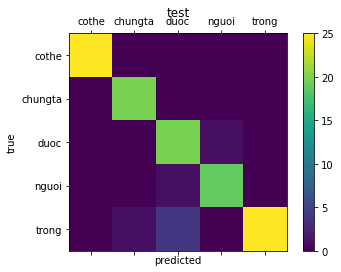

In [26]:
plotCM(y_true, y_predict, labels)

In [27]:
print(n_test)

{'cothe': 25, 'chungta': 20, 'duoc': 21, 'nguoi': 20, 'trong': 30}


## Test âm thu từ micro

In [28]:
print("Testing testDataSet")
n_correct = {'cothe': 0, 'chungta': 0, 'duoc': 0, 'nguoi': 0,'trong': 0}
y_testTrue = []
y_testPredict = []
labels = ['cothe', 'chungta', 'duoc', 'nguoi', 'trong']
for true_cname in testClass_names:
    for O in testDataSet[true_cname]:
        score = {cname: model.score(O, [len(O)]) for cname, model in models.items()}
        if (true_cname == max(score, key=score.get)): n_correct[true_cname] += 1
        y_testTrue.append(true_cname)
        y_testPredict.append(max(score, key = score.get))
        print(true_cname, score, 'predict:', max(score, key=score.get))

Testing testDataSet
chungta {'cothe': -156.05843252483922, 'chungta': -188.5098175158359, 'duoc': -119.43134111118295, 'nguoi': -502.96670427329104, 'trong': -584.0690807967635} predict: duoc
chungta {'cothe': -149.21120866066664, 'chungta': -82.85926081917718, 'duoc': -128.5935374196593, 'nguoi': -1777.8142097158764, 'trong': -690.2531693667312} predict: chungta
chungta {'cothe': -187.01327953023807, 'chungta': -79.50356662758963, 'duoc': -109.74566332892684, 'nguoi': -2757.1668632007472, 'trong': -273.12354659813496} predict: chungta
chungta {'cothe': -128.15320391944593, 'chungta': -77.24194294343371, 'duoc': -96.91999798388639, 'nguoi': -106.1780388231588, 'trong': -141.46423459648554} predict: chungta
chungta {'cothe': -267.4595379836476, 'chungta': -72.39228924179778, 'duoc': -120.88446270240814, 'nguoi': -3296.2911740203035, 'trong': -1388.1889115562979} predict: chungta
duoc {'cothe': -35.63745039598357, 'chungta': -27.746901757081893, 'duoc': -19.24092074481348, 'nguoi': -30.5

In [29]:
#np.around(models['trong'].transmat_, 2)

In [30]:
for cname in testClass_names:
    print('Accuracy:', cname, n_correct[cname]/n_testDataSet[cname])
print('All Accuracy:', sum(n_correct.values())/sum(n_testDataSet.values()))

Accuracy: chungta 0.8
Accuracy: duoc 1.0
Accuracy: trong 0.8
Accuracy: nguoi 0.8
Accuracy: cothe 1.0
All Accuracy: 0.88


c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass labels=['cothe', 'chungta', 'duoc', 'nguoi', 'trong'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


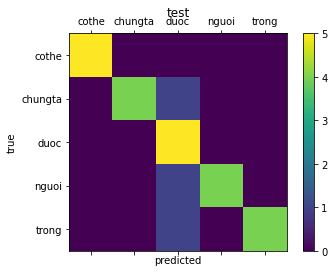

In [31]:
plotCM(y_testTrue, y_testPredict, labels)